In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FuncFormatter
from matplotlib import ticker
from PIL import Image
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
from fractions import Fraction
font = {'family' : 'Times New Roman',
    'weight' : 'light',
    'size'   : 13,
    }
plt.rc('font',family='Times New Roman')

matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Times New Roman'  # 用于正常数学文本
matplotlib.rcParams['mathtext.it'] = 'Times New Roman:italic'  # 用于斜体数学文本

#def curve_color():
def set_axis(axes,xmaj=0.5,xmin=0.125,ymaj=0.5,ymin=0.125,aspect=None):
    if aspect:
        axes.set_aspect(aspect)
    axes.minorticks_on()
    axes.tick_params(axis="both", which="major", direction="in", width=1, length=4, labelsize=10)
    axes.tick_params(axis="both", which="minor", direction="in", width=1, length=2, labelsize=10)

    axes.xaxis.set_major_locator(MultipleLocator(xmaj))
    axes.xaxis.set_minor_locator(MultipleLocator(xmin))
    axes.yaxis.set_major_locator(MultipleLocator(ymaj))
    axes.yaxis.set_minor_locator(MultipleLocator(ymin))                    
    axes.set_xlabel(r'$x$',fontdict={'size': 12})
    axes.set_ylabel(r'$u$',fontdict={'size': 12})
    #axes.set_xticks(fontsize=10)
    #axes.set_yticks(fontsize=10)
    


In [2]:
class solver:
    def __init__(self,nx=100,CFL=0.5,a_=1,init=None,bcs=None):
        """"
        nx: the number of cells, or the total number of nodes is nx+1
        nt: the number of iterations
        CFL: stable criterion, i.e. CFL=adt/dx
        a_: group velocity
        u_curr: u^n; u_next: u^{n+1}
        """
        self.nx=nx
        self.CFL=CFL
        self.a=a_
        if init==None:
            #init=lambda x: 0 if 0<x<0.3 else (1 if 0.3<=x<=0.6 else 1+2.5*(x-0.6))
            init=lambda x: 0 if -0.5<=x<-0.25 else (1 if -0.25<=x<=0.25 else 0)
        if bcs==None:
            bcs={'a':lambda t: 0, 'b': lambda t: 2}
        self.init=init
        self.bcs=bcs
        
        self.dx=1./nx
        self.dt=self.CFL*self.dx/self.a
        self.x_range=np.arange(-0.5,0.5+self.dx,self.dx)
        self.t_range=np.arange(0,10+self.dt,self.dt)

        self.u_curr=np.zeros((nx+1,))
        self.u_next=np.zeros((nx+1,))
        for i in range(nx+1):
            self.u_curr[i]=self.init(i*self.dx-0.5)
        #self.u_curr[0]=self.bcs['a'](0)
        #self.u_curr[-1]=self.bcs['b'](0)
        #plt.plot(self.x_range,self.u_curr,color='b')
    
    def method(self, u_curr, u_next, tt):
        """"
        Calculate u_next with u_curr, update and return u_curr and u_next
        """
        pass
    
    def saves(self,arg):
        return
        #arg.append(self.u_curr)

    def solve(self, nt, arg_plot=None, arg_save=None):
        print('Solving the equation, nt: {}'.format(nt))
        if arg_plot and arg_plot['all']:
            arg_plot['all']['cmap'] = plt.get_cmap('Spectral')
            arg_plot['all']['norm'] = plt.Normalize(vmin=self.t_range.min(), vmax=self.t_range.max())
            arg_plot['fig']=plt.figure(dpi=120)
            arg_plot['axes']=plt.gca()
            set_axis(arg_plot['axes'],ymaj=arg_plot['ticks'][0],ymin=arg_plot['ticks'][1])
            
        for tt in range(nt+1):
            if arg_plot and tt%arg_plot['freq']==0:
                if arg_plot['single']:
                    print('t: {}'.format(tt))
                    arg_plot['fig']=plt.figure(dpi=120)
                    arg_plot['axes']=plt.gca()
                    set_axis(arg_plot['axes'],ymaj=arg_plot['ticks'][0],ymin=arg_plot['ticks'][1])
                    plt.plot(self.x_range,self.u_curr,color=arg_plot['single']['color'])
                    plt.show()
                if arg_plot['all']:
                    color = arg_plot['all']['cmap'](arg_plot['all']['norm'](tt*self.dt))
                    plt.plot(self.x_range,self.u_curr,color=color)

            if arg_save and tt%arg_save['freq']==0:
                #self.saves(arg_save['list'])
                arg_save['list'].append((tt,self.u_curr.copy()))
            #self.u_curr, self.u_next=self.method(self.u_curr, self.u_next)
            #print(222)
            self.u_curr, self.u_next=self.method(self.u_curr.copy(), self.u_next.copy(), tt)
        if arg_plot and arg_plot['all']:
            sm = plt.cm.ScalarMappable(norm=arg_plot['all']['norm'], cmap=arg_plot['all']['cmap'])
            cbar = plt.colorbar(sm, ax=arg_plot['axes'], label='Time')
            cbar.set_ticks(np.linspace(self.t_range.min(), self.t_range.max(), 5))  # 设置刻度
            plt.show()
 

In [3]:
plot_all={'cmap':None,'norm':None}
plot_single={'color':'b'}
set_single=lambda freq, ticks=[0.5,0.125]: {'all':None,'single':plot_single, 'fig':None, 'axes':None, 'ticks':ticks, 'freq':freq}
set_all=lambda freq, ticks=[0.5,0.125]: {'all':plot_all,'single':None, 'fig':None, 'axes':None, 'ticks':ticks, 'freq':freq}
set_save=lambda _list, freq=1: {'list': _list, 'freq':freq}

In [4]:
class Upwind(solver):
    def __init__(self, nx=100, CFL=0.5, a_=1, init=None, bcs=None):
        super().__init__(nx, CFL, a_, init, bcs)
        self._list=[]
        print('Method: Upwind, nx: {}, dx: {}, CFL: {}, dt: {}'.format(self.nx, self.dx, self.CFL, self.dt))
    
    def method(self, u_curr, u_next, tt):
        return -self.CFL*(u_curr-np.roll(u_curr,shift=1))+u_curr, u_next
    
    def solve(self, nt):
        return solver.solve(self,nt,arg_plot=None,arg_save=set_save(self._list))
    
    def plot_result2(self, _range):
        print(len(self._list))
        plt.figure(dpi=120)
        set_axis(plt.gca(),ymaj=1,ymin=0.25)
        for i in _range:
            plt.plot(self.x_range,self._list[i][1],label=r'$t=$'+'{:.4f}'.format(self._list[i][0]*self.dt)+r', $i=$'+'{:d}'.format(self._list[i][0]))
            #plt.text(0.25,1.75,'t={:.5f}'.format(FTCS_list1[i][0]*testFTCS_1.dt))
        plt.ylim(-0.2, 3.2)
        plt.legend()#loc='upper left'
        plt.show()

Method: Upwind, nx: 100, dx: 0.01, CFL: 0.5, dt: 0.005
Solving the equation, nt: 20000
20001


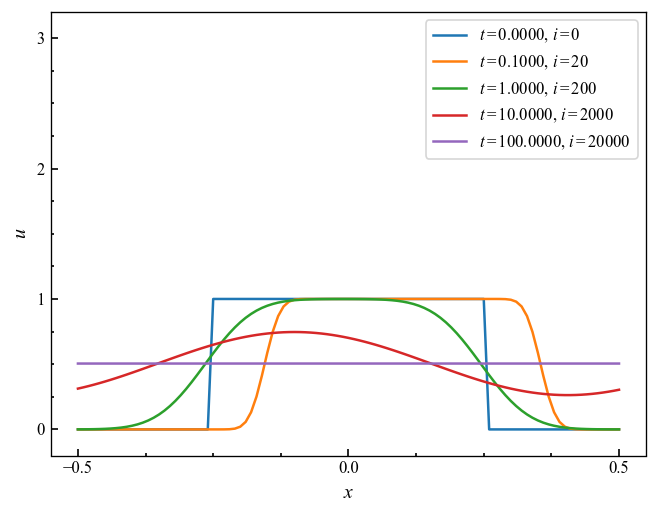

In [11]:
test_Upwind=Upwind(nx=100)
test_Upwind.solve(int(100/test_Upwind.dt))
test_Upwind.plot_result2([0,20, 200, 2000,20000])

In [6]:
class ImplicitEuler(solver):
    def __init__(self, nx=100, CFL=0.5, a_=1, init=None, bcs=None):
        super().__init__(nx, CFL, a_, init, bcs)
        self._list=[]
        self.matrix=np.zeros((nx+1, nx+1))
        self.matrix[0][-1]=-CFL/2
        self.matrix[-1][0]=CFL/2
        self.matrix[0][1]=CFL/2
        self.matrix[-1][-2]=-CFL/2
        self.matrix+=np.eye(nx+1)
        for i in range(1,len(self.matrix)-1):
            self.matrix[i][i-1]=-CFL/2
            self.matrix[i][i+1]=CFL/2
        print(self.matrix)
        #self.matrix=np.linalg.inv(self.matrix)
        #print(self.matrix)
        print('Method: Implicit Euler 1st order, nx: {}, dx: {}, CFL: {}, dt: {}'.format(self.nx, self.dx, self.CFL, self.dt))
    
    def method(self, u_curr, u_next, tt):
        #return self.CFL*(np.roll(u_curr,shift=1)-np.roll(u_curr,shift=-1))+u_curr, u_next
        #return self.matrix@u_curr, u_next
        return np.linalg.solve(self.matrix,u_curr), u_next
    
    def solve(self, nt):
        return solver.solve(self,nt,arg_plot=None,arg_save=set_save(self._list))
    
    def plot_result2(self, _range):
        print(len(self._list))
        plt.figure(dpi=120)
        set_axis(plt.gca(),ymaj=1,ymin=0.25)
        for i in _range:
            plt.plot(self.x_range,self._list[i][1],label=r'$t=$'+'{:.4f}'.format(self._list[i][0]*self.dt)+r', $i=$'+'{:d}'.format(self._list[i][0]))
            #plt.text(0.25,1.75,'t={:.5f}'.format(FTCS_list1[i][0]*testFTCS_1.dt))
        plt.ylim(-0.2, 3.2)
        plt.legend()#loc='upper left'
        plt.show()

[[ 1.    0.25  0.   ...  0.    0.   -0.25]
 [-0.25  1.    0.25 ...  0.    0.    0.  ]
 [ 0.   -0.25  1.   ...  0.    0.    0.  ]
 ...
 [ 0.    0.    0.   ...  1.    0.25  0.  ]
 [ 0.    0.    0.   ... -0.25  1.    0.25]
 [ 0.25  0.    0.   ...  0.   -0.25  1.  ]]
Method: Implicit Euler 1st order, nx: 100, dx: 0.01, CFL: 0.5, dt: 0.005
Solving the equation, nt: 20000
20001


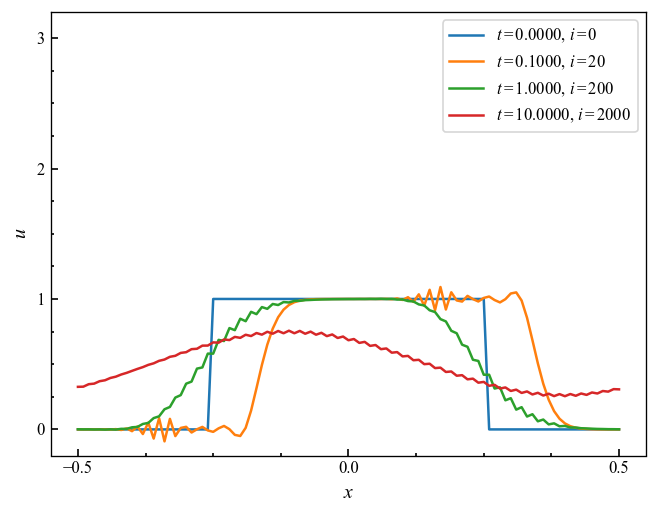

In [7]:
test_Euler=ImplicitEuler(nx=100)
test_Euler.solve(int(100/test_Euler.dt))
#test_Euler.plot_result2([0,20, 200, 2000])
test_Euler.plot_result2([0,20, 200, 2000])

20001


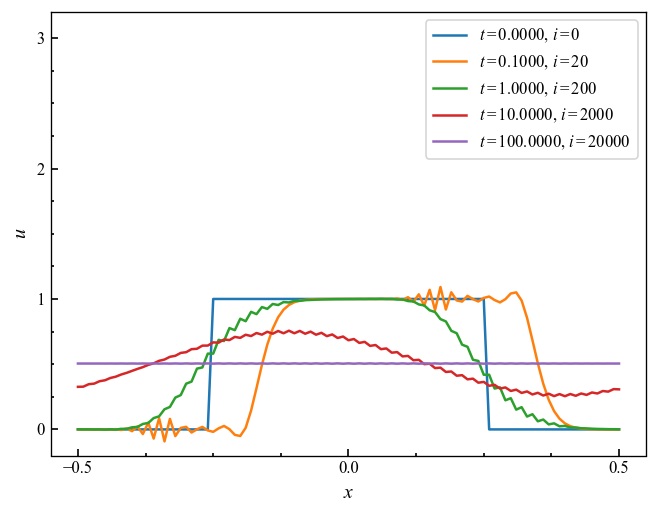

In [10]:

test_Euler.plot_result2([0,20, 200, 2000,20000])